# Lab 5: Data manipulation


In [1]:
options(repr.plot.width=6, repr.plot.height=5)

require(tidyverse)
require(stringr)
library(dplyr)
library(ggplot2)

Loading required package: tidyverse

Warning message:
“replacing previous import ‘vctrs::data_frame’ by ‘tibble::data_frame’ when loading ‘dplyr’”
── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.3     ✔ dplyr   1.0.0
✔ tidyr   1.1.0     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()



## `gather` and `spread`

Remember that `gather` transforms datasets from "wide" to "long," collecting different column names into a variable. `spread` does the opposite, turning "long" datasets into "wide" ones by spreading out a variable's values into the column names.

In [8]:
grades_wide = tribble(
  ~name,  ~`2015`, ~`2016`, ~`2017`,
'Roger',       83,      89,      93,
  'Jon',       92,      90,      93)
grades_wide

name,2015,2016,2017
<chr>,<dbl>,<dbl>,<dbl>
Roger,83,89,93
Jon,92,90,93


In [9]:
grades_long = grades_wide %>% gather(key=year, value=grade, `2015`:`2017`)
grades_long

name,year,grade
<chr>,<chr>,<dbl>
Roger,2015,83
Jon,2015,92
Roger,2016,89
Jon,2016,90
Roger,2017,93
Jon,2017,93


In [10]:
grades_long %>% spread(key=year, value=grade)

name,2015,2016,2017
<chr>,<dbl>,<dbl>,<dbl>
Jon,92,90,93
Roger,83,89,93


## MLB Data

This dataset contains information for player-seasons in the American League from 2015 to 2018. For those unfamiliar with baseball:
* `PA`: Plate Appearances, the number of times a player came up to bat.
* `HR`: number of home runs.
* `BBrate`: The number of walks (BBs) as a percentage of plate appearances.
* `BB`: The number of walks.
* `K`: The number of strikeouts.
* `AVG`: A batters batting average.
* `FB`: The number of fly balls a batter hit.

Note: Also recall the functions `unite`, `separate`, and `complete`.

In [11]:
mlb = read_csv('https://raw.githubusercontent.com/rogerfan/stats306_f18_labs/master/mlb.csv')
head(mlb)

Parsed with column specification:
cols(
  year = col_double(),
  name = col_character(),
  team = col_character(),
  division = col_character(),
  PA = col_double(),
  HR = col_double(),
  BBrate = col_character(),
  BB_K = col_character(),
  AVG = col_double(),
  FB = col_double(),
  playerid = col_double()
)



year,name,team,division,PA,HR,BBrate,BB_K,AVG,FB,playerid
<dbl>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<dbl>
2016,Abraham Almonte,Indians,Central,194,1,4.1 %,8/42,0.264,43,5486
2017,Abraham Almonte,Indians,Central,195,3,10.3 %,20/46,0.233,34,5486
2015,Adam Moore,Indians,Central,4,0,0.0 %,0/2,0.250,1,9362
2016,Adam Moore,Indians,Central,5,0,0.0 %,0/4,0.000,1,9362
2018,Adam Plutko,Indians,Central,2,0,0.0 %,0/0,0.000,0,15846
2018,Adam Rosales,Indians,Central,21,1,4.8 %,1/5,0.211,7,9682


### Problem 1

Note that `BBrate` and `BB_K` were read in as strings. Clean up these variables and convert them to numeric variables, noting that `BB_K` should be two variables named `BB` and `K`.

In [12]:
dat1 = mlb %>% mutate(BBrate = as.numeric(str_replace(BBrate, ' %', ''))/100) %>%
    separate(BB_K, into = c("BB", "K"), sep="/", convert=TRUE)
head(dat1)

year,name,team,division,PA,HR,BBrate,BB,K,AVG,FB,playerid
<dbl>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<int>,<int>,<dbl>,<dbl>,<dbl>
2016,Abraham Almonte,Indians,Central,194,1,0.041,8,42,0.264,43,5486
2017,Abraham Almonte,Indians,Central,195,3,0.103,20,46,0.233,34,5486
2015,Adam Moore,Indians,Central,4,0,0.000,0,2,0.250,1,9362
2016,Adam Moore,Indians,Central,5,0,0.000,0,4,0.000,1,9362
2018,Adam Plutko,Indians,Central,2,0,0.000,0,0,0.000,0,15846
2018,Adam Rosales,Indians,Central,21,1,0.048,1,5,0.211,7,9682


### Problem 2

Calculate the HR per FB rate for each team and year. Convert this to a wide dataset, so your variables should be `division`, `team`, and `2015`-`2018`, where values are the HR/FB rate. Note that you should ensure that `division` is still in the dataset.

Create a variable called `increased`, which checks if the HR/FB rate was higher in 2018 than it was in 2015 for that team.

In [13]:
dat2 = mlb %>% group_by(division, team, year) %>% summarize(HR_FB=sum(HR)/sum(FB)) %>%
    spread(key=year, value=HR_FB) %>% mutate(increased = `2018` > `2015`)

head(dat2)

`summarise()` regrouping output by 'division', 'team' (override with `.groups` argument)



division,team,2015,2016,2017,2018,increased
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<lgl>
Central,Indians,0.09964727,0.1198402,0.1314103,0.12936849,TRUE
Central,Royals,0.08997253,0.1041215,0.1225681,0.10319635,TRUE
Central,Tigers,0.09611152,0.1376147,0.1077051,0.09244314,FALSE
Central,Twins,0.10641201,0.1308677,0.1312420,0.09869494,FALSE
Central,White_Sox,0.10594947,0.1220799,0.1352785,0.13573620,TRUE
East,Blue_Jays,0.16168582,0.1460446,0.1417910,0.13721264,FALSE


Turn this back into a "long" dataset and create a plot of HR/FB rate on year. Color it by `team`, facet it by `division`, and choose the linetype according to the `increased` variable.

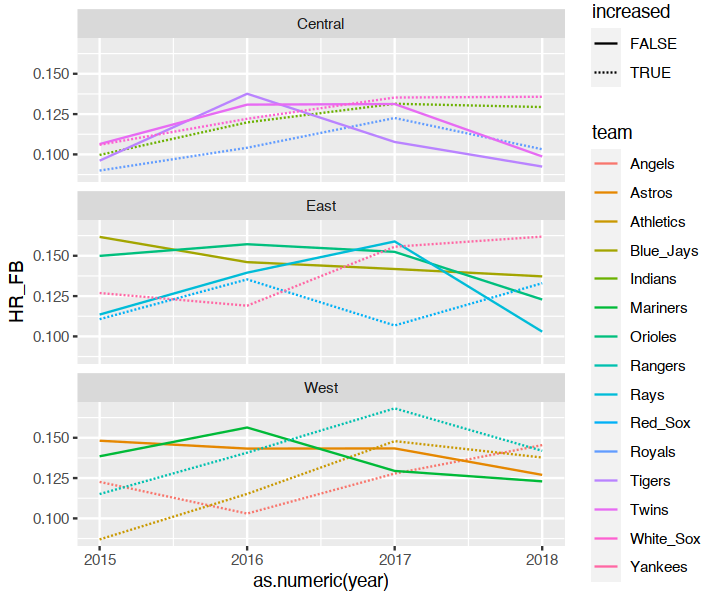

In [14]:
dat2b = dat2 %>% gather(key=year, value=HR_FB, `2015`:`2018`)

ggplot(dat2b, aes(color=team, linetype=increased, x=as.numeric(year), y=HR_FB)) + 
    geom_line() +
    facet_wrap(~ division, nrow=3)

### Problem 3

Go back to `mlb` and calculate total HRs and PAs per year per team. Create a wide version of this dataset. So there should be a `team` variable, then eight variables tracking values: `HR_2015`, `HR_2016`, `HR_2017`, `HR_2018`, `PA_2015`, `PA_2016`, `PA_2017`, and `PA_2018`.

Hint: Once you calculate the values you can use a `gather`, `unite`, and `spread` in that order to create the wide version.

In [15]:
dat3 = mlb %>% group_by(team, year) %>% summarize(HR=sum(HR), PA=sum(PA)) %>%
    gather(key=variable, value=value, HR, PA) %>%
    unite(var_year, variable, year) %>%
    spread(key=var_year, value=value)
head(dat3)

`summarise()` regrouping output by 'team' (override with `.groups` argument)



team,HR_2015,HR_2016,HR_2017,HR_2018,PA_2015,PA_2016,PA_2017,PA_2018
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Angels,169,155,165,192,5519,5901,5178,5336
Astros,224,193,232,201,5866,5851,5984,5997
Athletics,124,138,188,227,5573,4487,4687,6248
Blue_Jays,211,216,209,191,5196,6015,5842,5313
Indians,113,180,205,211,4758,5896,6051,6219
Mariners,169,220,190,166,5002,6079,5789,5609


### Problem 4

Remove player-seasons with less than 200 `PA`. Then, for each player, calculate the change in `AVG` from the previous year to the current year and the change from the current year to the next year. Store these as two variables. If data on the previous or next year is not present, then the corresponding variable should be `NA`.

Once you have these two variables, make two plots where the `x`-axis is current year `AVG` and the `y`-axis is each of these difference variables. Can you make both plots with a single command using faceting? (Hint: you may need to do some additional data transformations to accomplish this.) What conclusions can you draw from these plots?

In [16]:
options(repr.plot.width=7, repr.plot.height=5)

dat4 = mlb %>% filter(PA >= 200) %>%
    unite(playerid, playerid, name) %>%
    complete(playerid, year) %>%
    group_by(playerid) %>%
    arrange(playerid, year) %>%
    mutate(AVG_diff = AVG - lag(AVG),
           next_AVG_diff = lead(AVG) - AVG) %>%
    filter(!is.na(AVG))

head(dat4)

playerid,year,team,division,PA,HR,BBrate,BB_K,AVG,FB,AVG_diff,next_AVG_diff
<chr>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
10059_Max Stassi,2018,Astros,West,250,8,9.2 %,23/74,0.226,45,NA,NA
10155_Mike Trout,2015,Angels,West,682,41,13.5 %,92/158,0.299,162,NA,0.016
10155_Mike Trout,2016,Angels,West,681,29,17.0 %,116/137,0.315,153,0.016,-0.009
10155_Mike Trout,2017,Angels,West,507,33,18.5 %,94/90,0.306,142,-0.009,0.006
10155_Mike Trout,2018,Angels,West,608,39,20.1 %,122/124,0.312,159,0.006,NA
10231_Jose Iglesias,2015,Tigers,Central,454,2,5.5 %,25/44,0.300,85,NA,-0.045


Warning message:
“Removed 652 rows containing missing values (geom_point).”


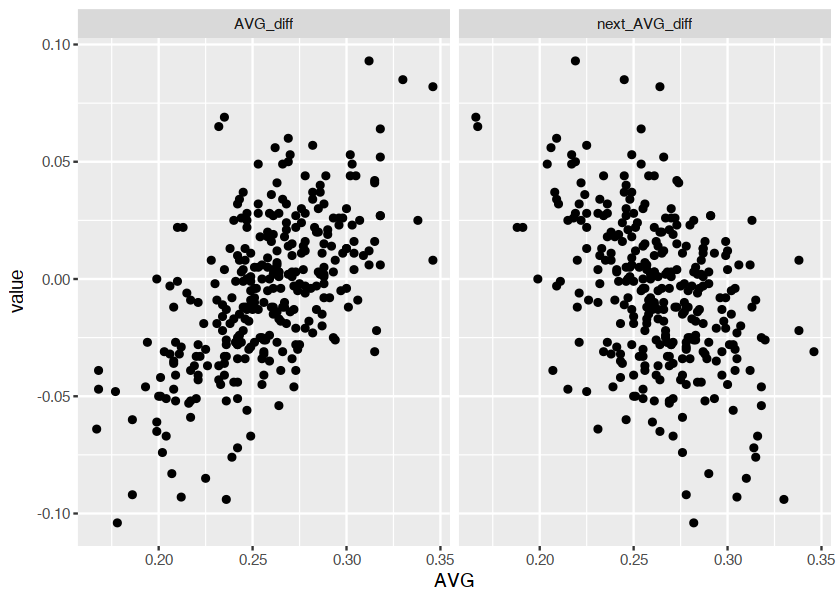

In [17]:
dat4b = dat4 %>% gather(key=variable, value=value, AVG_diff, next_AVG_diff)

ggplot(dat4b, aes(x=AVG, y=value)) + geom_point() + facet_wrap(~variable)

## Midterm Review

In [2]:
load("lab5.Rdata")

lab5.RData contains two data frames: listing, demo. Let's take a look. listing basically has all the info you would find on a rental page.
Some demographic info by zipcode are in demo

In [3]:
listing %>% glimpse()

Rows: 23,624
Columns: 29
$ accommodates                <dbl> 2, 2, 6, 1, 2, 2, 2, 2, 3, 1, 2, 4, 3, 4,…
$ amenities                   <chr> "{}", "{\"Wireless Internet\",\"Air condi…
$ availability_30             <int> 29, 18, 3, 0, 6, 22, 10, 0, 3, 20, 17, 27…
$ bathrooms                   <dbl> 1.0, 1.0, 1.0, 1.0, 1.0, NA, 1.5, 1.0, 2.…
$ bed_type                    <chr> "Real Bed", "Real Bed", "Real Bed", "Real…
$ bedrooms                    <dbl> 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,…
$ beds                        <dbl> 1, 1, 3, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 2,…
$ cancellation_policy         <chr> "flexible", "flexible", "flexible", "flex…
$ city                        <chr> "palmdale", "acton", "acton", "los angele…
$ has_availability            <lgl> NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, N…
$ host_id                     <int> 44800067, 84615808, 71743973, 41646908, 8…
$ id                          <int> 8909380, 14078522, 13006928, 7898757, 160…
$ instant_bookable         

In [4]:
demo %>% head()

,zipcode,population,median_household_income,mean_household_income
,<chr>,<int>,<chr>,<chr>
1,601,17982,10816,20349
2,602,40260,16079,23282
3,603,52408,16804,26820
4,606,6331,12512,15730
5,610,28328,17475,23360
6,612,64816,17229,25590


### Goal: 
Airbnb is meant for home sharing, but there are hosts with more than 20 listings. This is more like commercial hotels without regulation than home sharing. We would like to identify such users and see what their impact is on the airbnb ecosystem.
### Step 1:
host_id is a unique identifier for host. id is a unique identifier for listing. Construct a table where for each host_id, we have the number of unique ids, and the mean review_scores_value for that host_id. Call this table tb1. Name the 3 resulting columns host_id, nid, and mean_review.

In [5]:
tb1 <- listing %>% group_by(host_id) %>% summarise(nid = length(unique(id)), mean_review = mean(review_scores_value))
head(tb1)

`summarise()` ungrouping output (override with `.groups` argument)



host_id,nid,mean_review
<int>,<int>,<dbl>
59,1,10.0
521,1,8.0
767,1,8.0
1158,1,10.0
3041,2,8.5
3144,1,10.0


### Step 2:

Look at a digital clock:
* if the minute is odd, Create a sequence of box plots, where the x axis is nid, and y axis is mean_review. Like the one in [lecture 7](https://github.com/terhorst/stats306/blob/master/lecture07/Lecture07.ipynb) right above the violin plot.
* if the minute is even, create a scatter plot of mean_review vs nid, add a smooth fitted line.
 
What do you see? If you have made both, what are the things that you can pick off from one plot but not the other?

Warning message:
“Removed 71 rows containing non-finite values (stat_boxplot).”


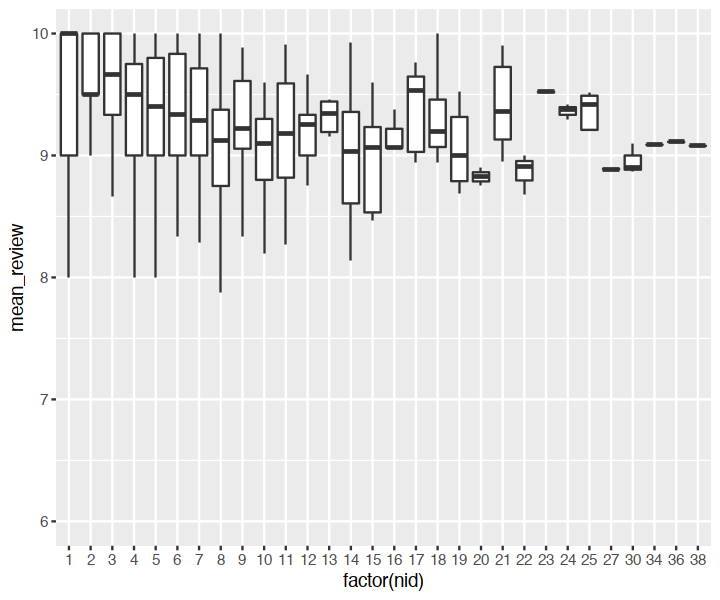

In [6]:
ggplot(data = tb1) + 
    geom_boxplot(mapping = aes(x = factor(nid), y = mean_review), outlier.shape = NA) + ylim(6,10)

`geom_smooth()` using method = 'gam' and formula 'y ~ s(x, bs = "cs")'



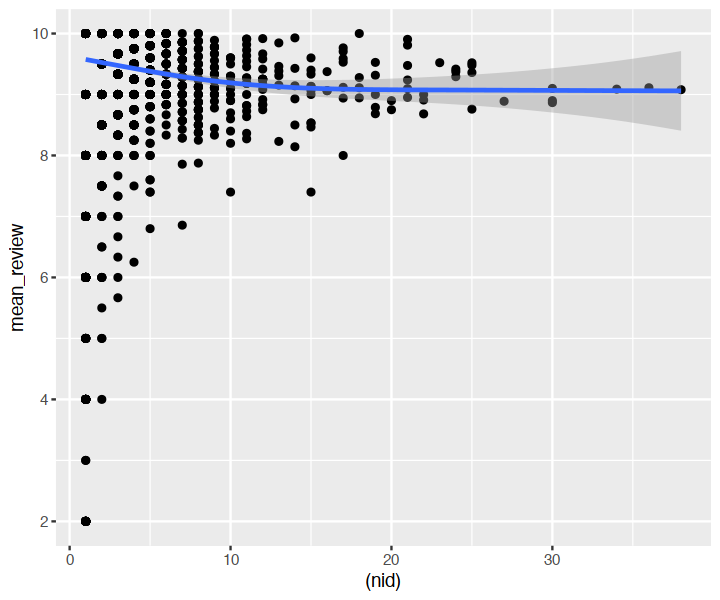

In [7]:
ggplot(data = tb1, mapping = aes(x = (nid), y = mean_review)) + 
    geom_point() + geom_smooth()

### Step 3:
Let's define commercial hosts to be hosts with >= 5 listings. Create a column in listing indicating if this row has a commercial host. (hint: you need to merge tables for this, at least I needed)

In [8]:
tb2 <- tb1 %>% mutate(if_commer = nid >= 5) %>% select(host_id, if_commer)
listing <- listing %>% left_join(tb2)

Joining, by = "host_id"



### Step 4:
In listing, find for each zipcode, the total number of listings, the number of commercial listings (any listing by a commercial host is a commercial listing), and the mean price of all listings; retain only rows with more than 25 listings. Name this table tb3, name four columns zipcode, nlist, ncomlist, and mp.

In [9]:
tb3 <- listing %>% group_by(zipcode) %>% summarise(nlist = n(), ncomlist = sum(if_commer), mp = mean(price, na.rm = T)) %>%
filter(nlist > 25)

`summarise()` ungrouping output (override with `.groups` argument)



### Step 5:
In tb3, add a column of boolean value indicating if this zipcode is "commercial heavy". We define commercial heavy as the number commercial listings exceeding 20% of the total amount of listings. Name the result tb4.

In [10]:
tb4 <- tb3 %>% mutate(com_heavy = (ncomlist/nlist) > 0.2)
tb4 %>% head

zipcode,nlist,ncomlist,mp,com_heavy
<chr>,<int>,<int>,<dbl>,<lgl>
,249,24,134.32114,FALSE
90004,290,62,115.34028,TRUE
90005,195,69,90.78351,TRUE
90006,279,185,60.90323,TRUE
90007,113,41,59.18584,TRUE
90008,46,1,111.21739,FALSE
